### Finetune DINOv2 for semantic segmentation task

Why DINOv2 and not SAM: 
* DINOv2 is faster to train small enough for laptop GPU
* DINOv2 feature are multipurpose(classification, depth estimation etc)

But SAM is also worth to try


In [1]:
import fiftyone as fo
import torch
from torchvision.transforms import v2
from torch.hub import load
import pytorch_lightning as pl
import cv2
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings("ignore")

from preprocess import coco_annotations_to_masks, resize_images_folder
from train import prepare_model, DataModule

/home/teshbek/anaconda3/envs/torch_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/teshbek/anaconda3/envs/torch_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using fiftyone to look at data

In [2]:
# A name for the dataset
name = "briges"

# The directory containing the dataset to import
RAW_IMAGES = 'data/BrigeImages/images'
ANN_PATH = 'data/BrigeImages/instances_default.json'

dataset = fo.Dataset.from_dir(
    labels_path= ANN_PATH,
    dataset_type=fo.types.COCODetectionDataset,
    data_path=RAW_IMAGES,
    name=name)

In [3]:
session = fo.launch_app(dataset)

Create segmentation masks and resize images for convenience

In [4]:
prepare_images = False
if prepare_images:
    DOWNSCALE_FACTOR = 6
    orig_masks_folder_path = coco_annotations_to_masks(ann_path=ANN_PATH, images_folder=RAW_IMAGES, ext='JPG')
    resized_images_folder_path = resize_images_folder(RAW_IMAGES, DOWNSCALE_FACTOR, ext='JPG', interpolation=cv2.INTER_AREA)
    resized_masks_folder_path = resize_images_folder(RAW_IMAGES + '_masks', DOWNSCALE_FACTOR, ext='png', interpolation=cv2.INTER_NEAREST)

Create train and validation datasets:

In [5]:
resized_images_folder_path = 'data/BrigeImages/images_6x_downscaled'
resized_masks_folder_path = 'data/BrigeImages/images_masks_6x_downscaled'
all_labeled_images_names = [img for img in os.listdir(resized_images_folder_path) if os.path.isfile(os.path.join(resized_masks_folder_path, img.split(".")[0] + ".png"))]


Here is how model can be trained:

In [12]:
segmentator = prepare_model()
# train_size here defines number of images in train dataset  
dm = DataModule(resized_images_folder_path, resized_masks_folder_path, train_size=50)

MAX_EPOCHS = 10
trainer = pl.Trainer(max_epochs=MAX_EPOCHS,
                     precision='16-mixed',  #Faster training on RTX GPUs
                     accelerator='cuda' if torch.cuda.is_available() else 'cpu',  
                     check_val_every_n_epoch=5)
                     #enable_progress_bar=False

trainer.fit(model=segmentator,
            datamodule=dm)

Using cache found in /home/teshbek/.cache/torch/hub/facebookresearch_dinov2_main


Dataset len: 109


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


Dataset mean and std: tensor([102.9221, 105.5417,  97.7115]), tensor([78.5406, 74.1163, 71.4406])
Dataset len: 109
Train dataset len: 50
Val dataset len: 59



  | Name       | Type              | Params
-------------------------------------------------
0 | net        | SegmentationNet   | 22.7 M
1 | loss       | BCEWithLogitsLoss | 0     
2 | train_loss | MeanMetric        | 0     
3 | val_loss   | MeanMetric        | 0     
4 | test_loss  | MeanMetric        | 0     
-------------------------------------------------
664 K     Trainable params
22.1 M    Non-trainable params
22.7 M    Total params
90.892    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Here is the validation metric for this training run:

In [14]:
trainer.callback_metrics['val/jaccard_best'].item()

0.11428165435791016

Results of experements with loss for different train sizes:

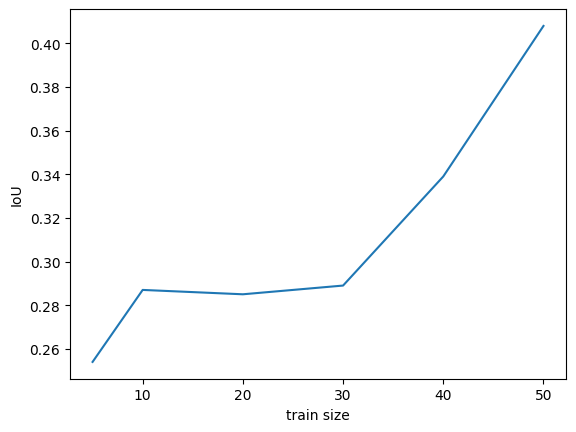

In [20]:
train_sizes = [50,    40,    30,    20,   10,     5]
IoU         = [0.408, 0.339, 0.289, 0.285, 0.287, 0.254]


plt.plot(train_sizes, IoU)
plt.xlabel('train size')
plt.ylabel('IoU')
plt.show()

More training data - better quality(obviously)

### Eval model with trained weights

In [48]:
checkpoint_path = 'weights/example.ckpt'
segmentator = prepare_model(checkpoint_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
segmentator = segmentator.eval().to(device)

Using cache found in /home/teshbek/.cache/torch/hub/facebookresearch_dinov2_main


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


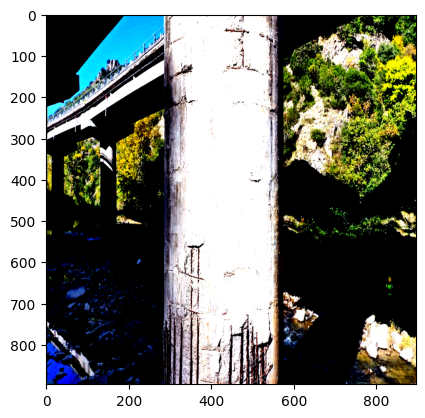

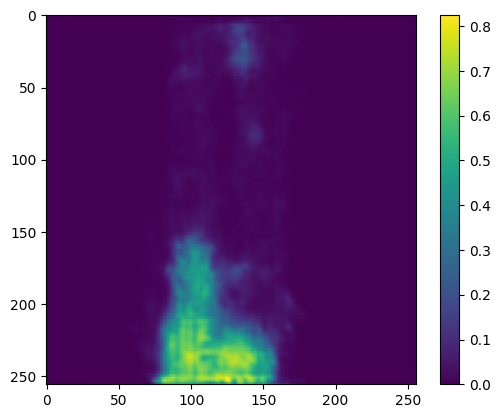

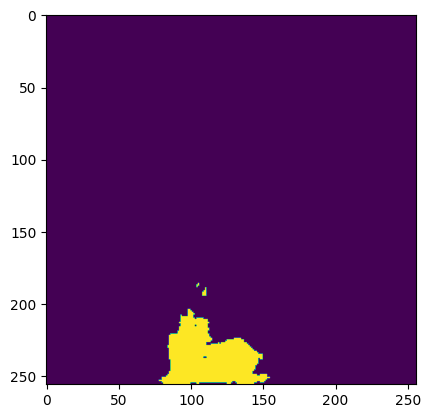

In [62]:
# Path to testing image, images with nubmer larger than 121 is not labeled
image_path = "data/BrigeImages/images_6x_downscaled/DJI_0122.JPG"

img_transform = v2.Compose([
    v2.Resize((14*64,14*64)),
    v2.ToTensor(),
    v2.Normalize(mean=[102.9221/255, 105.5417/255,  97.7115/255], std=[78.5406/255, 74.1163/255, 71.4406/255]),
])
image = Image.open(image_path).convert("RGB")
transformed_image = img_transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

sigm = torch.nn.Sigmoid()
predicted_mask = sigm(segmentator(transformed_image).cpu().detach()).numpy()
# Display the image and the mask
image = np.squeeze(transformed_image.cpu().detach()).numpy()
image = np.moveaxis(image, 0, -1)
plt.imshow(image)
plt.show()
pos = plt.imshow((np.squeeze(predicted_mask))) 
plt.colorbar(pos)
plt.show()
plt.imshow((np.squeeze(predicted_mask)>0.5)) 
plt.show()

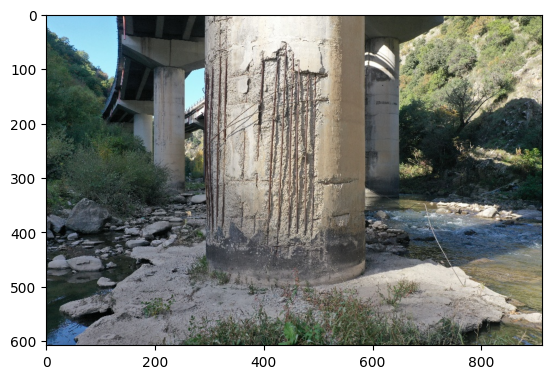

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


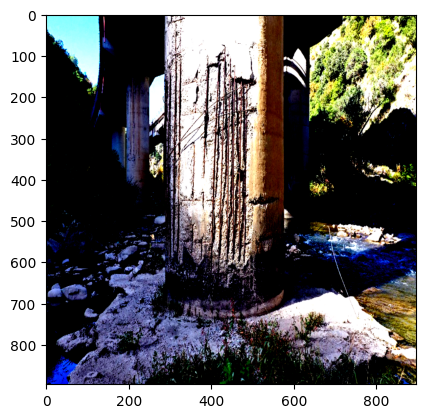

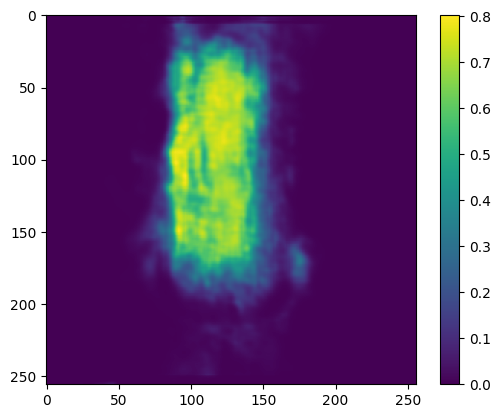

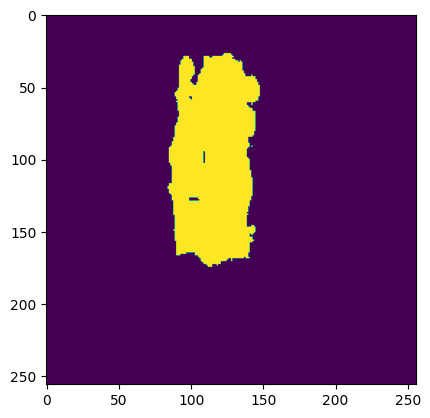

In [73]:
# Sample one random unannotated image
from random import sample 
import glob
from natsort import natsorted

image_paths = list(glob.glob(os.path.join(resized_images_folder_path, '*.JPG')))
image_paths = natsorted(image_paths, key=lambda y: y.lower())[109:]
image_path = sample(image_paths, 1)[0]

img_transform = v2.Compose([
    v2.Resize((14*64,14*64)),
    v2.ToTensor(),
    v2.Normalize(mean=[102.9221/255, 105.5417/255,  97.7115/255], std=[78.5406/255, 74.1163/255, 71.4406/255]),
])
image = Image.open(image_path).convert("RGB")
transformed_image = img_transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

sigm = torch.nn.Sigmoid()
predicted_mask = sigm(segmentator(transformed_image).cpu().detach()).numpy()


plt.imshow(image)
plt.show()
# Display the image and the mask
image = np.squeeze(transformed_image.cpu().detach()).numpy()
image = np.moveaxis(image, 0, -1)
plt.imshow(image)
plt.show()
# Mask from probabilities
pos = plt.imshow((np.squeeze(predicted_mask))) 
plt.colorbar(pos)
plt.show()
# Binary mask
plt.imshow((np.squeeze(predicted_mask)>0.5)) 
plt.show()

Overall model looks sutable for auto labeling with a little bit more tinkering. 

SAM might work better, and shoud be tested if there is time